In [1]:
# install Library rasterio
!pip install rasterio
# Import Library yang dibutuhkan
import rasterio
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 54.1 MB/s eta 0:00:00


In [2]:
# Membaca file raster .tif
# Sesuaikan lokasi path dari data raster yang sudah diexport dari GEE ke google drive kita
raster_file_path = '/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/sesi 1 & sesi 2/Data Pelatihan Sesi 1 & 2/S2_2024_Bali.tif'
dataset = rasterio.open(raster_file_path)

In [4]:
# untuk membuka semua band di data raster, kita bisa menggunakan
S2_image_all = dataset.read()
S2_image_all.shape

# Bisa kita lihat, format shape dari data tersebut adalah bands, row, column
# Untuk Plot data raster dengan matplotlib, kita harus menggunakan format shape row, column,bands
# Ubah format shape menjadi row, column, bands:
S2_image_all = S2_image_all.transpose(1, 2, 0)
S2_image_all.shape

# Deskripsi list bands pada data
desc = dataset.descriptions

In [5]:
print('Raster description: {desc}\n'.format(desc=desc))

Raster description: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')



In [6]:
## Membuat fungsi untuk membuat berbagai spectral index sekaligus
def calculate_spectral_indices(S2_image_all):
    # Extract bands dari S2_image_all
    blue = S2_image_all[:, :, 0]   # B2
    green = S2_image_all[:, :, 1]  # B3
    red = S2_image_all[:, :, 2]    # B4
    nir = S2_image_all[:, :, 3]    # B8
    swir1 = S2_image_all[:, :, 4]  # B11
    swir2 = S2_image_all[:, :, 5]  # B12

    # NDVI: (NIR - Red) / (NIR + Red)
    NDVI = (nir - red) / (nir + red)

    # NDBI: (SWIR1 - NIR) / (SWIR1 + NIR)
    NDBI = (swir1 - nir) / (swir1 + nir)

    # MNDWI: (Green - SWIR1) / (Green + SWIR1)
    MNDWI = (green - swir1) / (green + swir1)

    # NDMI: (SWIR2 - Green) / (SWIR2 + Green)
    NDMI = (swir2 - green) / (swir2 + green)

    # CMRI: NDVI - NDWI
    NDWI = (green - nir) / (green + nir)
    CMRI = NDVI - NDWI

    # Stack spectral indices
    spectral_indices = np.stack([NDVI, NDBI, MNDWI, NDMI, CMRI], axis=-1)

    # Concatenate atau menggabungkan original bands dengan the spectral indices
    S2_image_with_indices = np.concatenate((S2_image_all, spectral_indices), axis=-1)

    return S2_image_with_indices

In [7]:
# Membuat input data dengan 11 bands: 6 original bands dan 5 spectral indices
S2_image_with_indices = calculate_spectral_indices(S2_image_all)
print(S2_image_with_indices.shape)

(1095, 1256, 11)


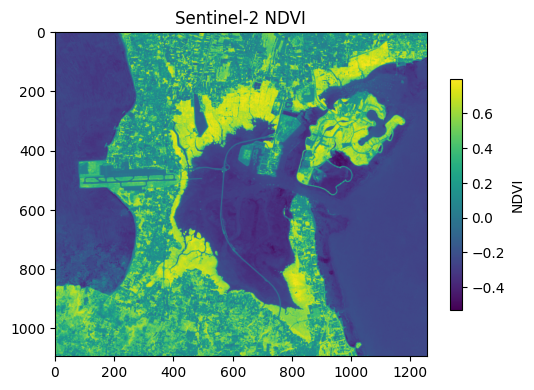

In [8]:
# Plot salah satu spectral indek
# Contoh NDVI berada di urutan ke-7 = index 6
# Plot NDVI
plt.figure(figsize=(6, 6))
plt.imshow(S2_image_with_indices[:,:,6], cmap='viridis')
plt.colorbar(label='NDVI',  shrink=0.5)
plt.title('Sentinel-2 NDVI')
plt.show()

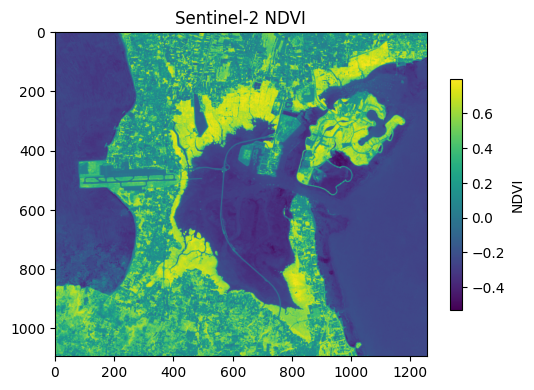

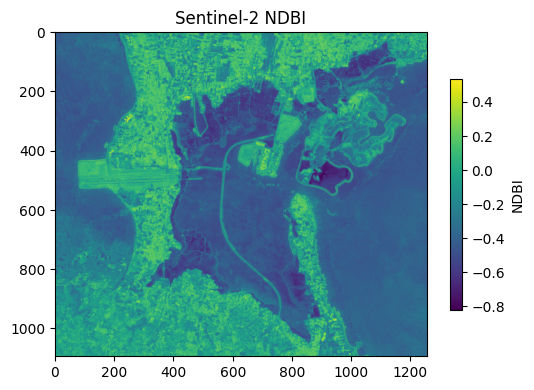

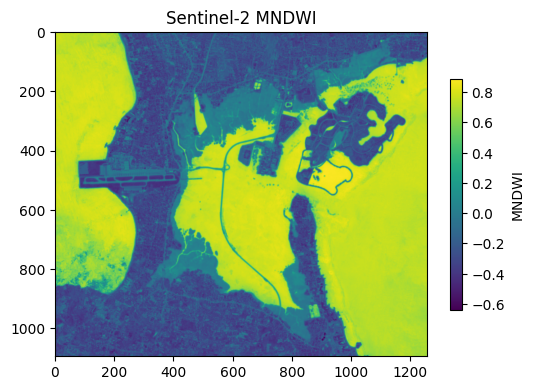

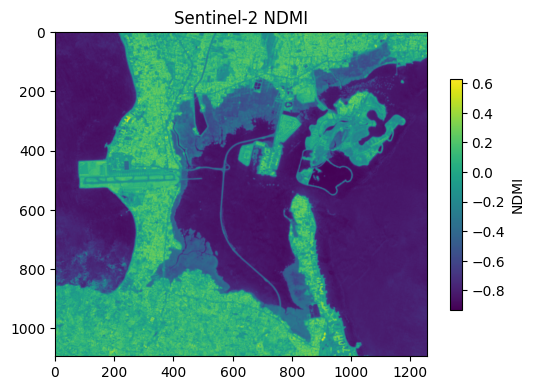

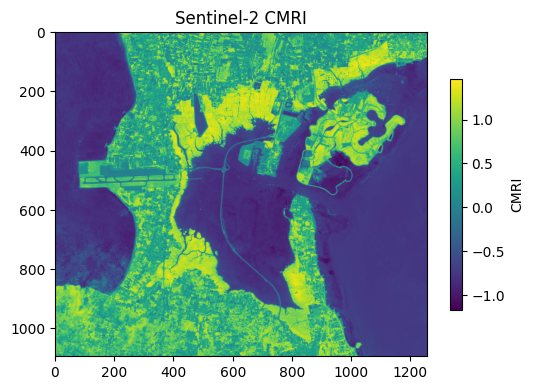

In [9]:
# Membuat Loop untuk plotting semua spectral index sekaligus:

# List nama spectral index
spectral_index_names = ['NDVI', 'NDBI', 'MNDWI', 'NDMI', 'CMRI']

# Start index untuk NDVI adalah index ke 6
start_index = 6

# Loop untuk semua spectral index dan plot semuanya
for i, index_name in enumerate(spectral_index_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(S2_image_with_indices[:, :, start_index + i], cmap='viridis')
    plt.colorbar(label=index_name, shrink=0.5)
    plt.title(f'Sentinel-2 {index_name}')
    plt.show()

In [11]:
## Menyimpan Citra Sentinel-2 Baru yang sudah terdapat spectral index didalamnya dengan total 11 bands
# langkah pertama adalah untuk mendapatkan metadat dari original dataset
meta = dataset.meta.copy()

# Kemudian memperbaharui meta data karena kita memiliki 11 bands
meta.update({
    "count": 11,  # 6 orignal bands + 5 spectral index
    "dtype": 'float32',  # Set the data type to float32
    "driver": 'GTiff'  # Save as GeoTIFF
})

meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 1256,
 'height': 1095,
 'count': 11,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(8.983152841195215e-05, 0.0, 115.1448853085709,
        0.0, -8.983152841195215e-05, -8.702878472549925)}

In [13]:
# Mendefiniskan deskripsi nama bands (original bands + spectral indices)
band_descriptions = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12',
                     'NDVI', 'NDBI', 'MDNWI', 'NDMI', 'CMRI']

# Tempat untuk menyimpan file tif.
output_file_path_S2New = '/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/sesi 1 & sesi 2/Data Pelatihan Sesi 1 & 2/S2_with_SpectralIndices_veru.tif'

# Export Sentinel-2 dengan sepctral indices
with rasterio.open(output_file_path_S2New, 'w', **meta) as dst:
    for i in range(11):
        dst.write(S2_image_with_indices[:, :, i], i + 1)  # Write each band

        # Menambahkan deskripsi band names untuk setiap bands
        dst.set_band_description(i + 1, band_descriptions[i])

In [14]:
# Verifikasi hasil export
with rasterio.open(output_file_path_S2New) as dataset2:
    desc = dataset2.descriptions
    print('Raster description: {desc}\n'.format(desc=desc))

Raster description: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDBI', 'MDNWI', 'NDMI', 'CMRI')



2. Pemrosesan Sample Data
2.1 Input nilai sampel dan ekstraksi nilai sampel

langkah selanjutnya adalah kita akan melakukan pengolahan sampel data, awalnya data sampel sudah kita buat terlebih dahulu melalui QGIS. dan setelah itu data sampel di upload ke dalam drive untuk di hubungkan dengan Google colab. data sampel inilah yang akan kita olah nantiknya, dan membaginya menjadi data training dan data testing

    Setelah mendapatkan sampel data untuk setiap kelas (Total = 500 sampel, 1 kelas = 100 sampel).
    Langkah selanjutnya adalah memproses data shapefile sampel kelas tersebut dengan data input raster kita, sehingga setiap sample akan memperoleh nilai piksel dari setiap bands (atau yang biasa dikenal dengan istilah extract pixels values).
    Disini kita akan membuat function untuk meng-ekstrak nilai piksel dari setiap bands yang terdapat point sampelnya.



In [15]:
!pip install rasterio
# Library yang dibutuhkan:
from rasterio.mask import mask
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
# Memanggil data shapefile point sampel
point_sample = gpd.read_file('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/sesi 1 & sesi 2/Data Pelatihan Sesi 1 & 2/Sample_Point_2024.shp')
point_sample.head()

,id,geometry
0,0,POINT (115.17556 -8.79431)
1,0,POINT (115.17531 -8.79462)
2,0,POINT (115.20101 -8.77793)
3,0,POINT (115.20903 -8.7708)
4,0,POINT (115.214 -8.78048)


In [18]:
# Mengetahui total sample pada setiap kelas:
print(point_sample['id'].value_counts())

id
0    100
1    100
2    100
3    100
4    100
Name: count, dtype: int64


In [20]:
# Membuka data Sentinel-2 yang sudah terdapat spectral indexnya
raster_input = rasterio.open('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/sesi 1 & sesi 2/Data Pelatihan Sesi 1 & 2/S2_with_SpectralIndices_veru.tif')

num_bands = raster_input.count
print('Total Bands: {n}\n'.format(n=num_bands))

Total Bands: 11



In [21]:
# Mengecek terlebih dahulu apakah CRS dari data point sample dan raster sama
# Apabila tidak sama maka CRS data point sample akan disamakan dengan CRS raster
if point_sample.crs != raster_input.crs:
    print("CRS berbeda, menyesuaikan CRS point sample dengan CRS raster...")
    point_sample = point_sample.to_crs(raster_input.crs)
    print("CRS point sample setelah disesuaikan:", point_sample.crs)
else:
    print("CRS point sample dan raster sudah sama.")

CRS point sample dan raster sudah sama.


In [22]:
## Membuat Fungsi Untuk Extract Pixel Raster Value dari data Shapefile
def extract_pixels_from_shapefile(shapefile, raster):
    training_samples = []
    for index, row in shapefile.iterrows():
        geometry = [row['geometry']]
        id_class = row['id']

        # Mask raster untuk mendapatkan pixel values yang terdapat dalam geometry shapefile
        out_image, out_transform = mask(raster, geometry, crop=True)

        # out_image shape: (bands, height, width) -- Reshape menjadi (pixels, bands)
        out_image = out_image.reshape(raster.count, -1).T  # Sekarang (pixels, bands)

        # menghapus Nan Pixels (Jika ada piksel dalam suatu band bernilai NaN)
        valid_pixels = out_image[~np.isnan(out_image).any(axis=1)]

        # Menambahkan valid pixel sebagai feature bersamaan dengan kelas labelnya
        for pixel in valid_pixels:
            training_samples.append((pixel, id_class))

    # Converts the tuple list kedalam numpy array
    features = np.array([sample[0] for sample in training_samples])  # Extract pixel values (features)
    labels = np.array([sample[1] for sample in training_samples])    # Extract class labels
    return features, labels

In [23]:
# Menggunakan funtion extract pixel values yang sudah dibuat untuk mendapatkan fatures dan label:
features, labels = extract_pixels_from_shapefile(point_sample, raster_input)

# Cek shape dari features dan labels
print(features.shape)
print(labels.shape)

(500, 11)
(500,)


In [24]:
## Kita lihat, feature terdapat 11 bands sedangkan labels hanya mewakili kelas label saja
#Final Pre-Processing sampel data
# Membuat mask untuk cek Nan values dari feature dan label
nan_mask = np.isnan(features).any(axis=1) | np.isnan(labels)

# Apabila ada Nan value maka akan dihapuskan
features = features[~nan_mask]
labels = labels[~nan_mask]

# Menghitung final total sampel masing-masing kelas
sample_new = pd.DataFrame({'class': labels})
print(sample_new['class'].value_counts())

class
0    100
1    100
2    100
3    100
4    100
Name: count, dtype: int64


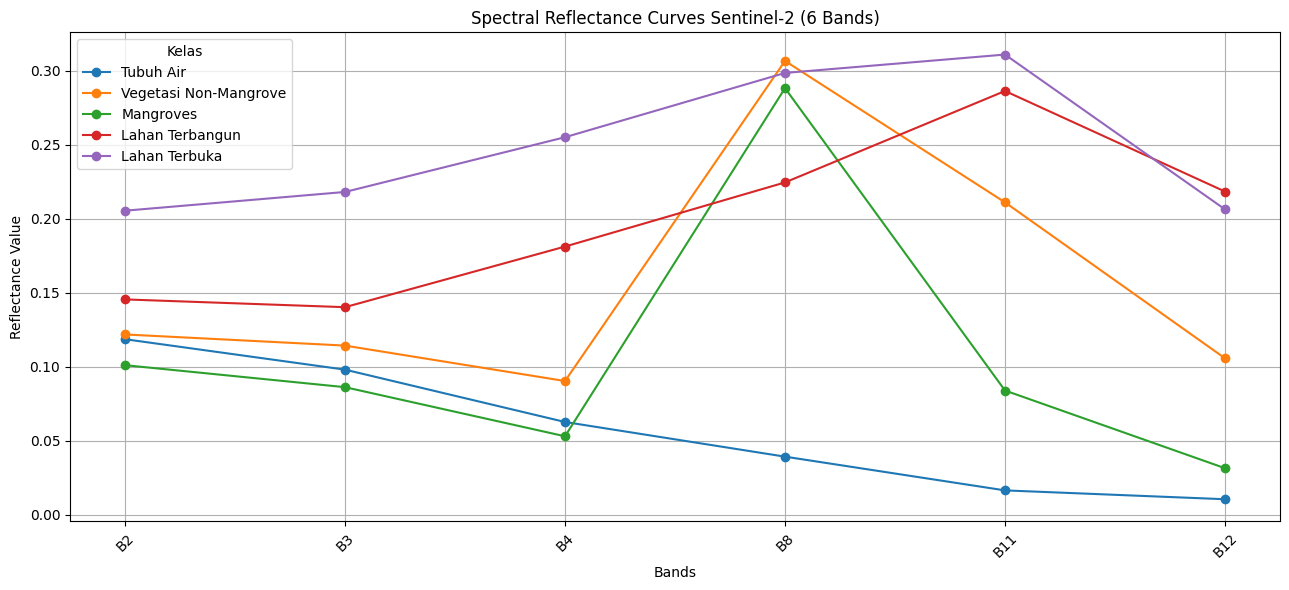

In [25]:
## Membuat Spectral Reflectance Curves setiap kelas
## Disini kita akan membuat spectral curves untuk setiap kelas pada 6 original bands
# Mendefiniskan band yang akan digunakan dan nama kelasnya
band_list = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
nama_kelas = ['Tubuh Air', 'Vegetasi Non-Mangrove', 'Mangroves', 'Lahan Terbangun', 'Lahan Terbuka']

# Memilih 6 bands pertama dari variable features
features_6_bands = features[:, :6]

# Plotting figure
plt.figure(figsize=(13, 6))

# Menggunakan Loop untuk setiap kelas dan menghitung nilai rata2 untuk setiap bands
for class_id in range(5):
    # Memilih frature yang sesuai dengan kelasnya
    class_features = features_6_bands[labels == class_id]

    # menghitung nilai rata2 setiap kelas dari seluruh bands
    mean_reflectance = np.mean(class_features, axis=0)

    # Plot spectral curves untuk setiap kelas
    plt.plot(band_list, mean_reflectance, label=nama_kelas[class_id], marker='o')

# Menambahkan title dan label
plt.title('Spectral Reflectance Curves Sentinel-2 (6 Bands)')
plt.xlabel('Bands')
plt.ylabel('Reflectance Value')
plt.legend(title='Kelas')

# Display the plot
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
## 2.2 Membuat Training dan testing Data
## selanjutnya kita akan membagi data point sampel tersebut menjadi data training dan juga data testing yang akan di gunakan untuk proses machine learning nantiknya

from sklearn.model_selection import train_test_split

# Split data: 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 11) (100, 11) (400,) (100,)


In [28]:
# Menyimpan numpy X_train, X_test, y_train, and y_test kedalam folder data GOC2 untuk digunakan Minggu depan
np.save('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/sesi 1 & sesi 2/Data Pelatihan Sesi 1 & 2/X_train.npy', X_train)
np.save('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/sesi 1 & sesi 2/Data Pelatihan Sesi 1 & 2/X_test.npy', X_test)
np.save('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/sesi 1 & sesi 2/Data Pelatihan Sesi 1 & 2/y_train.npy', y_train)
np.save('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/sesi 1 & sesi 2/Data Pelatihan Sesi 1 & 2/y_test.npy', y_test)